# Binary Prediction of Smoker Status using Bio-Signals
## Index

- Preparing enviorment and data
    - Importing libraries
    - Loading the dataset
    - Dirtying the dataset
- Data Analysis
    - Analysis of the missing values with missigno and dropping useless rows
    - Train & Test split
    - Analysis of features values, distributions and correlations
- Feature engineering & preprocessor pipeline creation 
    - Build custom pipelines to create new features
        - BMI
        - Eyesight
        - Pulse pressure
        - Blood pressure
        - AST/ALT ratio
    - Create pipelines for imputing & scaling
    - Compose the final preprocessor
- Model Selection
    - Evaluation of the performance of each classifier via cross-validation
        - Dummy
        - Logistic Regression
        - KNN
        - SVM
        - Decision Tree
        - Random Forest
        - GBM (Gradient Boosting Machine)
        - AdaBoost
        - XGBoost
    - Refinement of the best models via random search
        - PCA
        - LDA
        - Random Forest
        - GBM
        - SVM
- Best Model Hypertune
    - Fine tune of the best classifier via successive halving
    - Build train-validation accuracy and reduce overfitting
    - Build ROC curve
    - Tune the threshold
- Final Model Evaluation

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import seaborn as sns
import missingno as msno
from scipy.stats import loguniform
import itertools
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, cross_validate
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, roc_auc_score, f1_score
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as IMBPipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('smokers_dataset.csv')
dataset

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,1,45,155,55,71.0,1.2,1.5,1,1,122,...,56,118,12.1,1,0.8,23,15,15,1,0
1,2,20,170,85,92.0,1.5,1.2,1,1,110,...,44,79,15.9,1,0.8,22,22,19,0,1
2,3,30,170,85,91.0,1.2,1.5,1,1,114,...,52,122,16.4,1,0.9,26,20,25,1,1
3,4,35,180,75,81.0,0.7,0.7,1,1,123,...,51,176,15.9,1,1.3,16,13,53,0,1
4,5,60,165,55,82.0,1.5,1.5,1,1,118,...,45,141,15.5,1,0.9,26,21,44,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24996,40,175,60,73.0,1.5,1.5,1,1,121,...,65,66,16.7,1,0.9,20,12,15,0,0
24996,24997,40,175,60,79.0,0.9,1.0,1,1,114,...,71,72,14.3,1,1.0,23,16,14,0,0
24997,24998,40,175,70,85.0,1.2,1.0,1,1,118,...,72,89,15.8,1,1.1,29,39,76,1,1
24998,24999,40,175,85,91.0,1.0,0.9,1,1,132,...,45,105,16.4,1,1.1,19,20,50,0,1


# Introducing missing data
To enhance the realism of our dataset, we're intentionally introducing missing values, simulating common real-world data inconsistencies.

In [3]:
# Seed for reproducibility
np.random.seed(42)
random.seed(42)

def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace=False)
    X[indexes] = np.nan
    return X

def add_missing_rows(df, amount):
    X = df.copy()
    rows, cols = X.shape
    size = amount if amount >= 1 else int(rows * amount)
    indexes = np.random.choice(rows, size, replace=False) + 0.5
    for i in indexes:
        X.loc[i] = np.full((cols,), np.nan)
    X = X.sort_index().reset_index(drop=True)
    return X

columns_to_modify = dataset.columns.drop(['id', 'smoking'])
random_num = [random.uniform(0.001, 0.05) for _ in range(len(dataset.columns)-2)] #picking a random % of values to modify per column
for col, rn in zip(columns_to_modify, random_num):
    dataset[col] = add_missing(dataset[col], rn)

# Adding missing rows - 1% of the total rows
dataset = add_missing_rows(dataset, 0.01) #add missing rows

# Visualizing Missing Data with Missingno

Leveraging the Missingno library, we efficiently visualize the distribution and pattern of missing values in our dataset, aiding in understanding data completeness.

<AxesSubplot:>

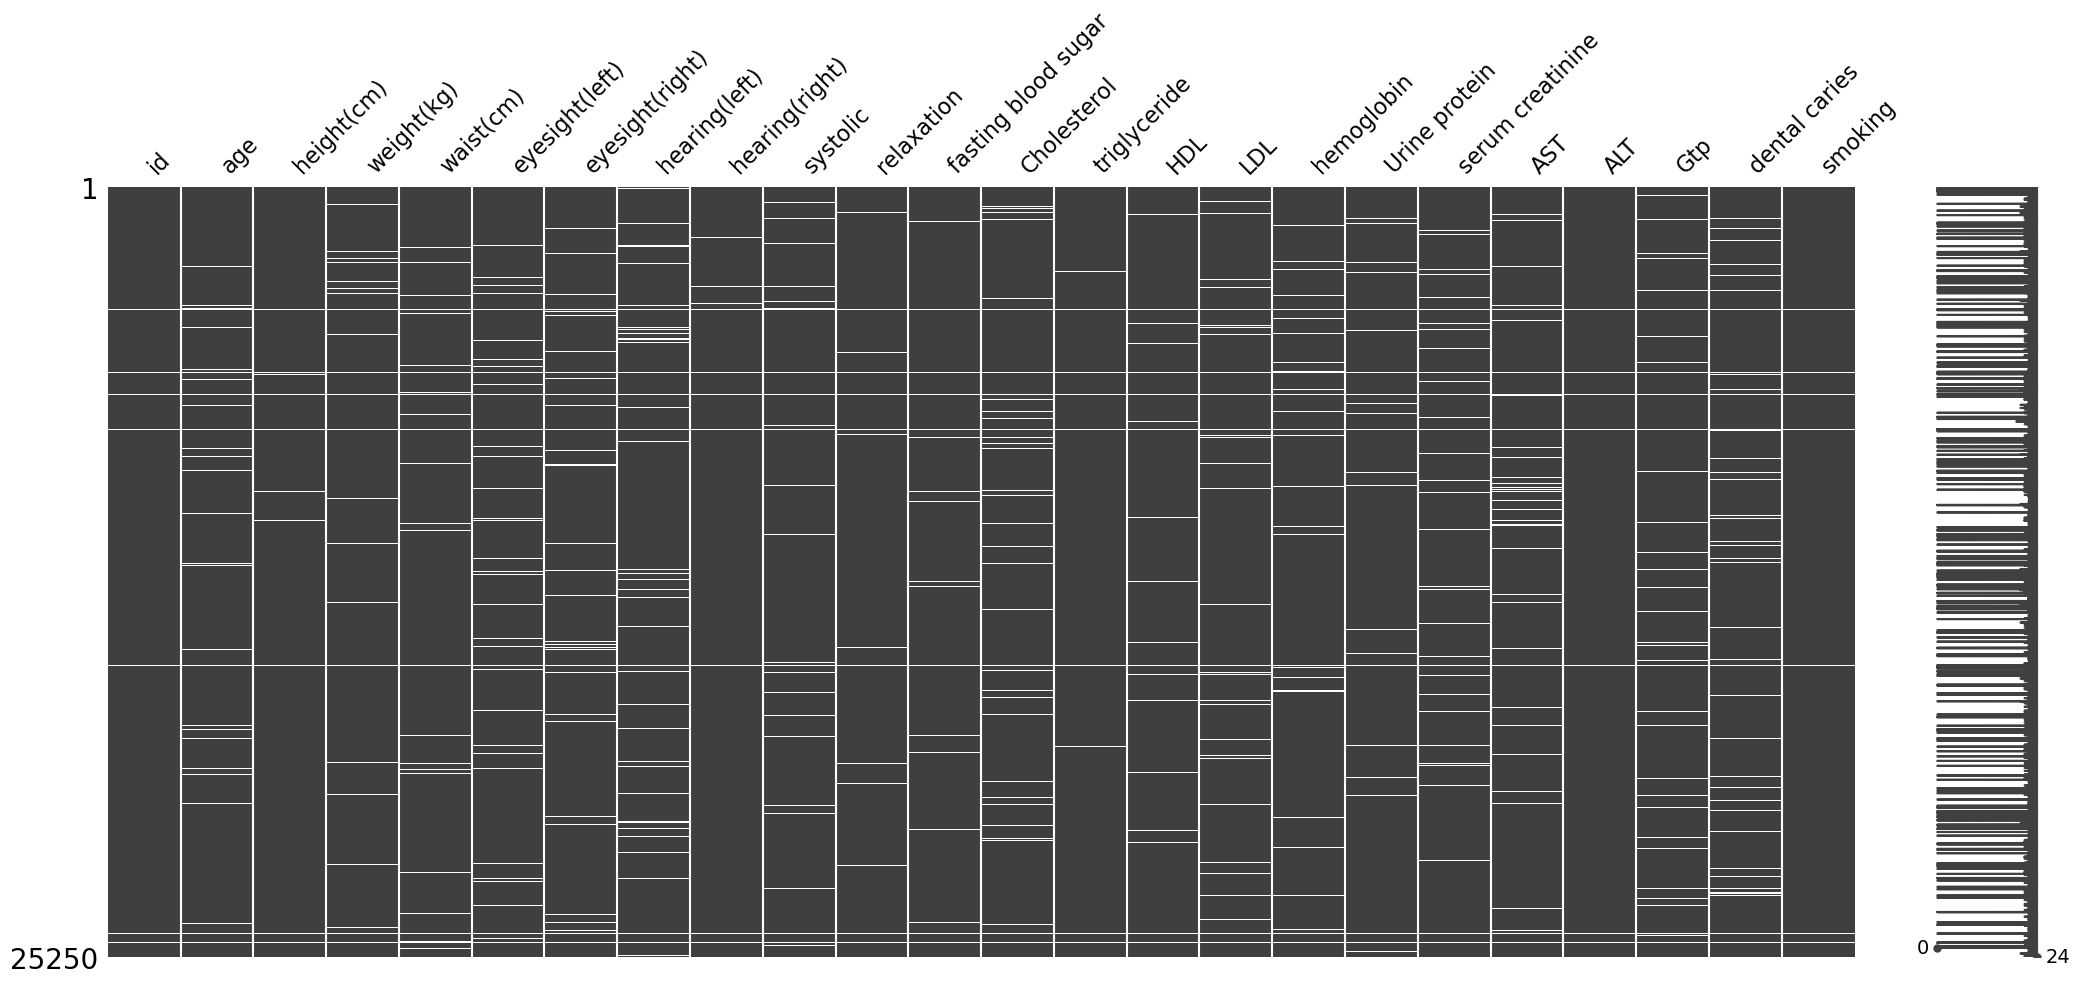

In [4]:
# Visualize the missing values in the dataset
msno.matrix(dataset)

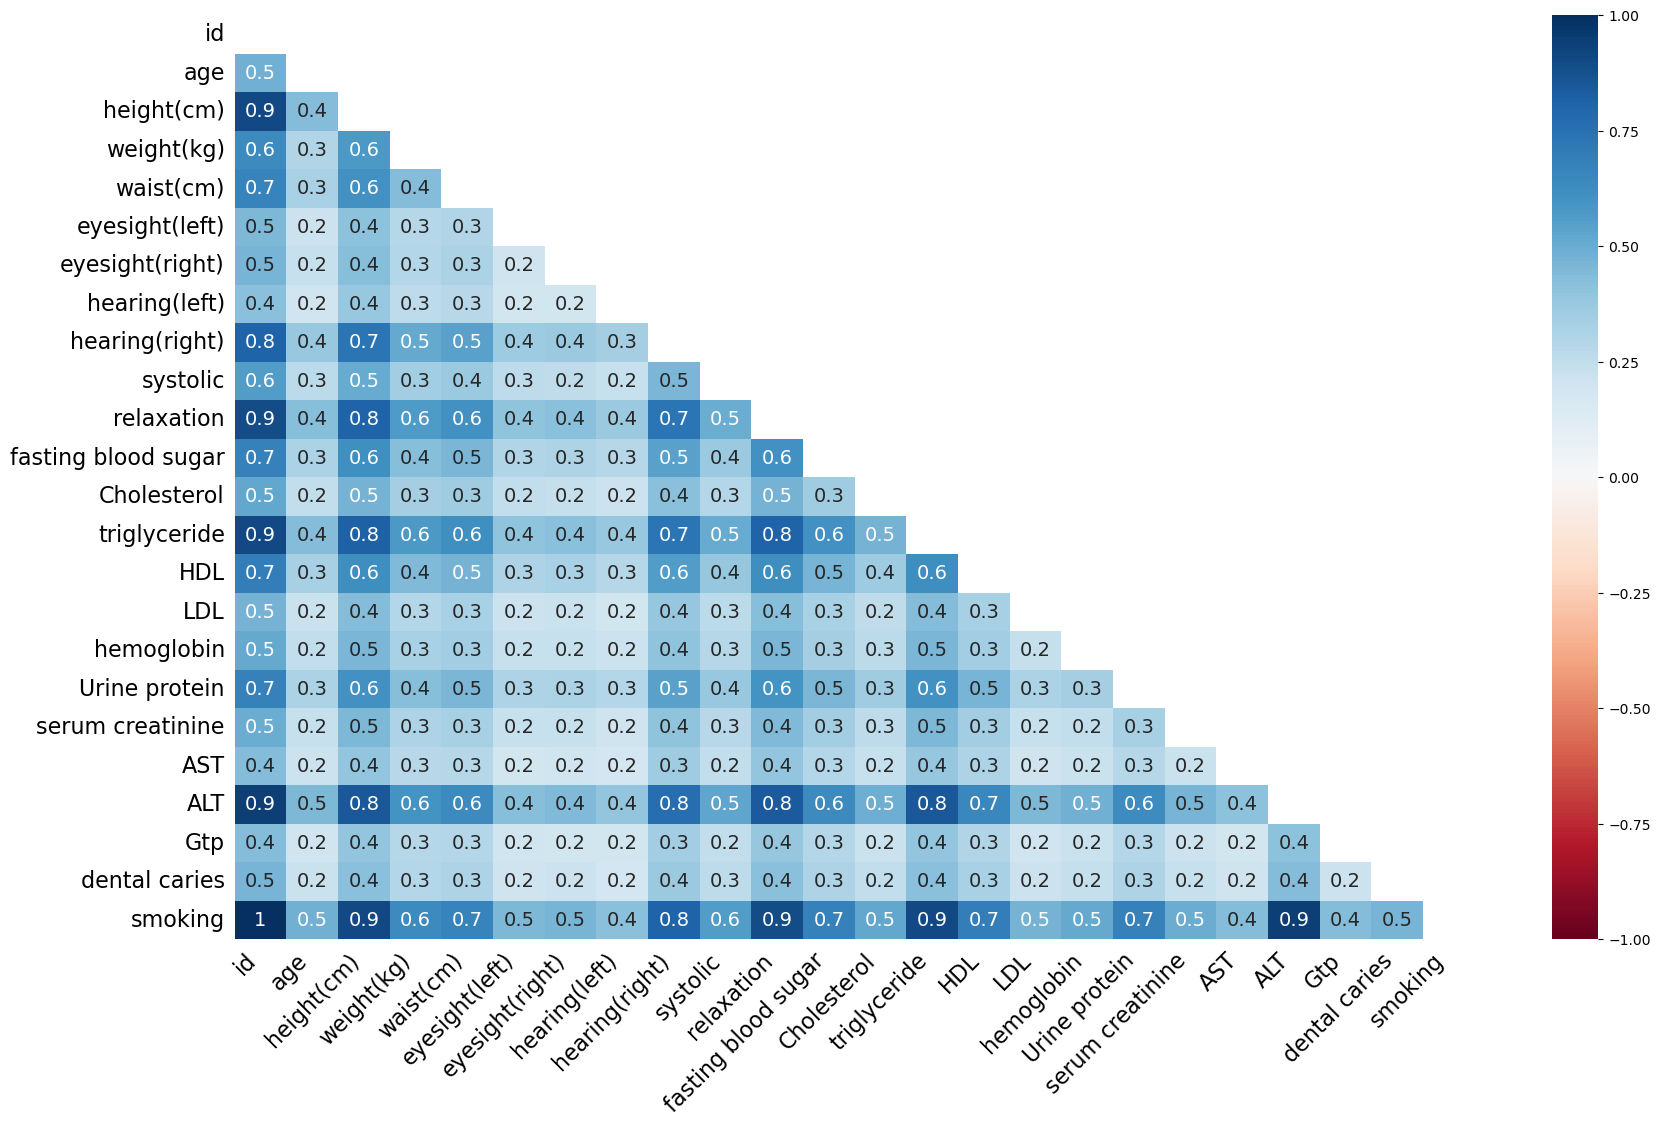

In [5]:
# Visualizing the correlation heatmap of missing values
msno.heatmap(dataset)
plt.show()

In [6]:
# Counting the number of missing values in each column
missing_values_count = dataset.isna().sum()
missing_values_count

id                      250
age                    1058
height(cm)              305
weight(kg)              611
waist(cm)               548
eyesight(left)         1177
eyesight(right)        1103
hearing(left)          1367
hearing(right)          381
systolic                791
relaxation              311
fasting blood sugar     542
Cholesterol             894
triglyceride            307
HDL                     518
LDL                    1071
hemoglobin              942
Urine protein           545
serum creatinine        996
AST                    1266
ALT                     282
Gtp                    1262
dental caries          1130
smoking                 250
dtype: int64

# Data Cleaning: Dropping and Counting

Removed 'id' column, dropped rows with NaN in 'smoking', and counted unique values across all columns.

In [7]:
# Drop the 'id' column
dataset = dataset.drop('id', axis=1)

# Drop rows where 'smoking' column has null values
dataset = dataset.dropna(subset=['smoking'])

# Get the number of unique values for each column
dataset.nunique()

age                     15
height(cm)              13
weight(kg)              22
waist(cm)              443
eyesight(left)          17
eyesight(right)         15
hearing(left)            2
hearing(right)           2
systolic                92
relaxation              67
fasting blood sugar    172
Cholesterol            194
triglyceride           373
HDL                     94
LDL                    183
hemoglobin             122
Urine protein            5
serum creatinine        20
AST                     93
ALT                    141
Gtp                    256
dental caries            2
smoking                  2
dtype: int64

# Splitting Dataset into Train and Test Sets

Divided the dataset into training and testing sets to ensure unbiased analysis in subsequent data exploration and modeling phases.

In [8]:
# Splitting the dataset into train and test sets
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# Detailed Test Set Analysis: Statistics and Visualizations

Examined test set by assessing percentiles, mean, and standard deviation; created feature distribution plots using Seaborn, and constructed a correlation matrix to explore feature interrelations.

In [9]:
# Calculating descriptive statistics for each column in the dataset
descriptive_stats = train_set.describe()
descriptive_stats

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,20000.000000,19956.000000,19705.000000,19761.000000,19244.000000,19324.000000,19091.000000,19898.000000,19573.000000,19952.000000,...,19788.000000,19362.000000,19445.000000,19750.000000,19390.000000,19190.000000,19976.000000,19178.000000,19300.000000,20000.000000
mean,44.440950,165.237472,67.246892,83.099190,1.005768,0.999524,1.024619,1.024224,122.606192,76.925621,...,55.708763,114.834160,14.805698,1.075089,0.893945,25.593590,26.726272,36.572583,0.201865,0.438400
std,11.846921,8.793051,12.554477,8.935597,0.412705,0.386192,0.154965,0.153746,12.688192,8.964568,...,13.912989,28.576176,1.442595,0.351760,0.179220,8.685084,15.278182,31.388530,0.401403,0.496203
min,20.000000,135.000000,30.000000,56.000000,0.100000,0.100000,1.000000,1.000000,83.000000,50.000000,...,25.000000,28.000000,6.900000,1.000000,0.100000,6.000000,1.000000,5.000000,0.000000,0.000000
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,122.000000,78.000000,...,53.000000,114.000000,15.000000,1.000000,0.900000,24.000000,23.000000,27.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,33.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,130.000000,123.000000,9.900000,9.900000,2.000000,2.000000,203.000000,121.000000,...,121.000000,1660.000000,19.100000,5.000000,5.900000,180.000000,220.000000,590.000000,1.000000,1.000000


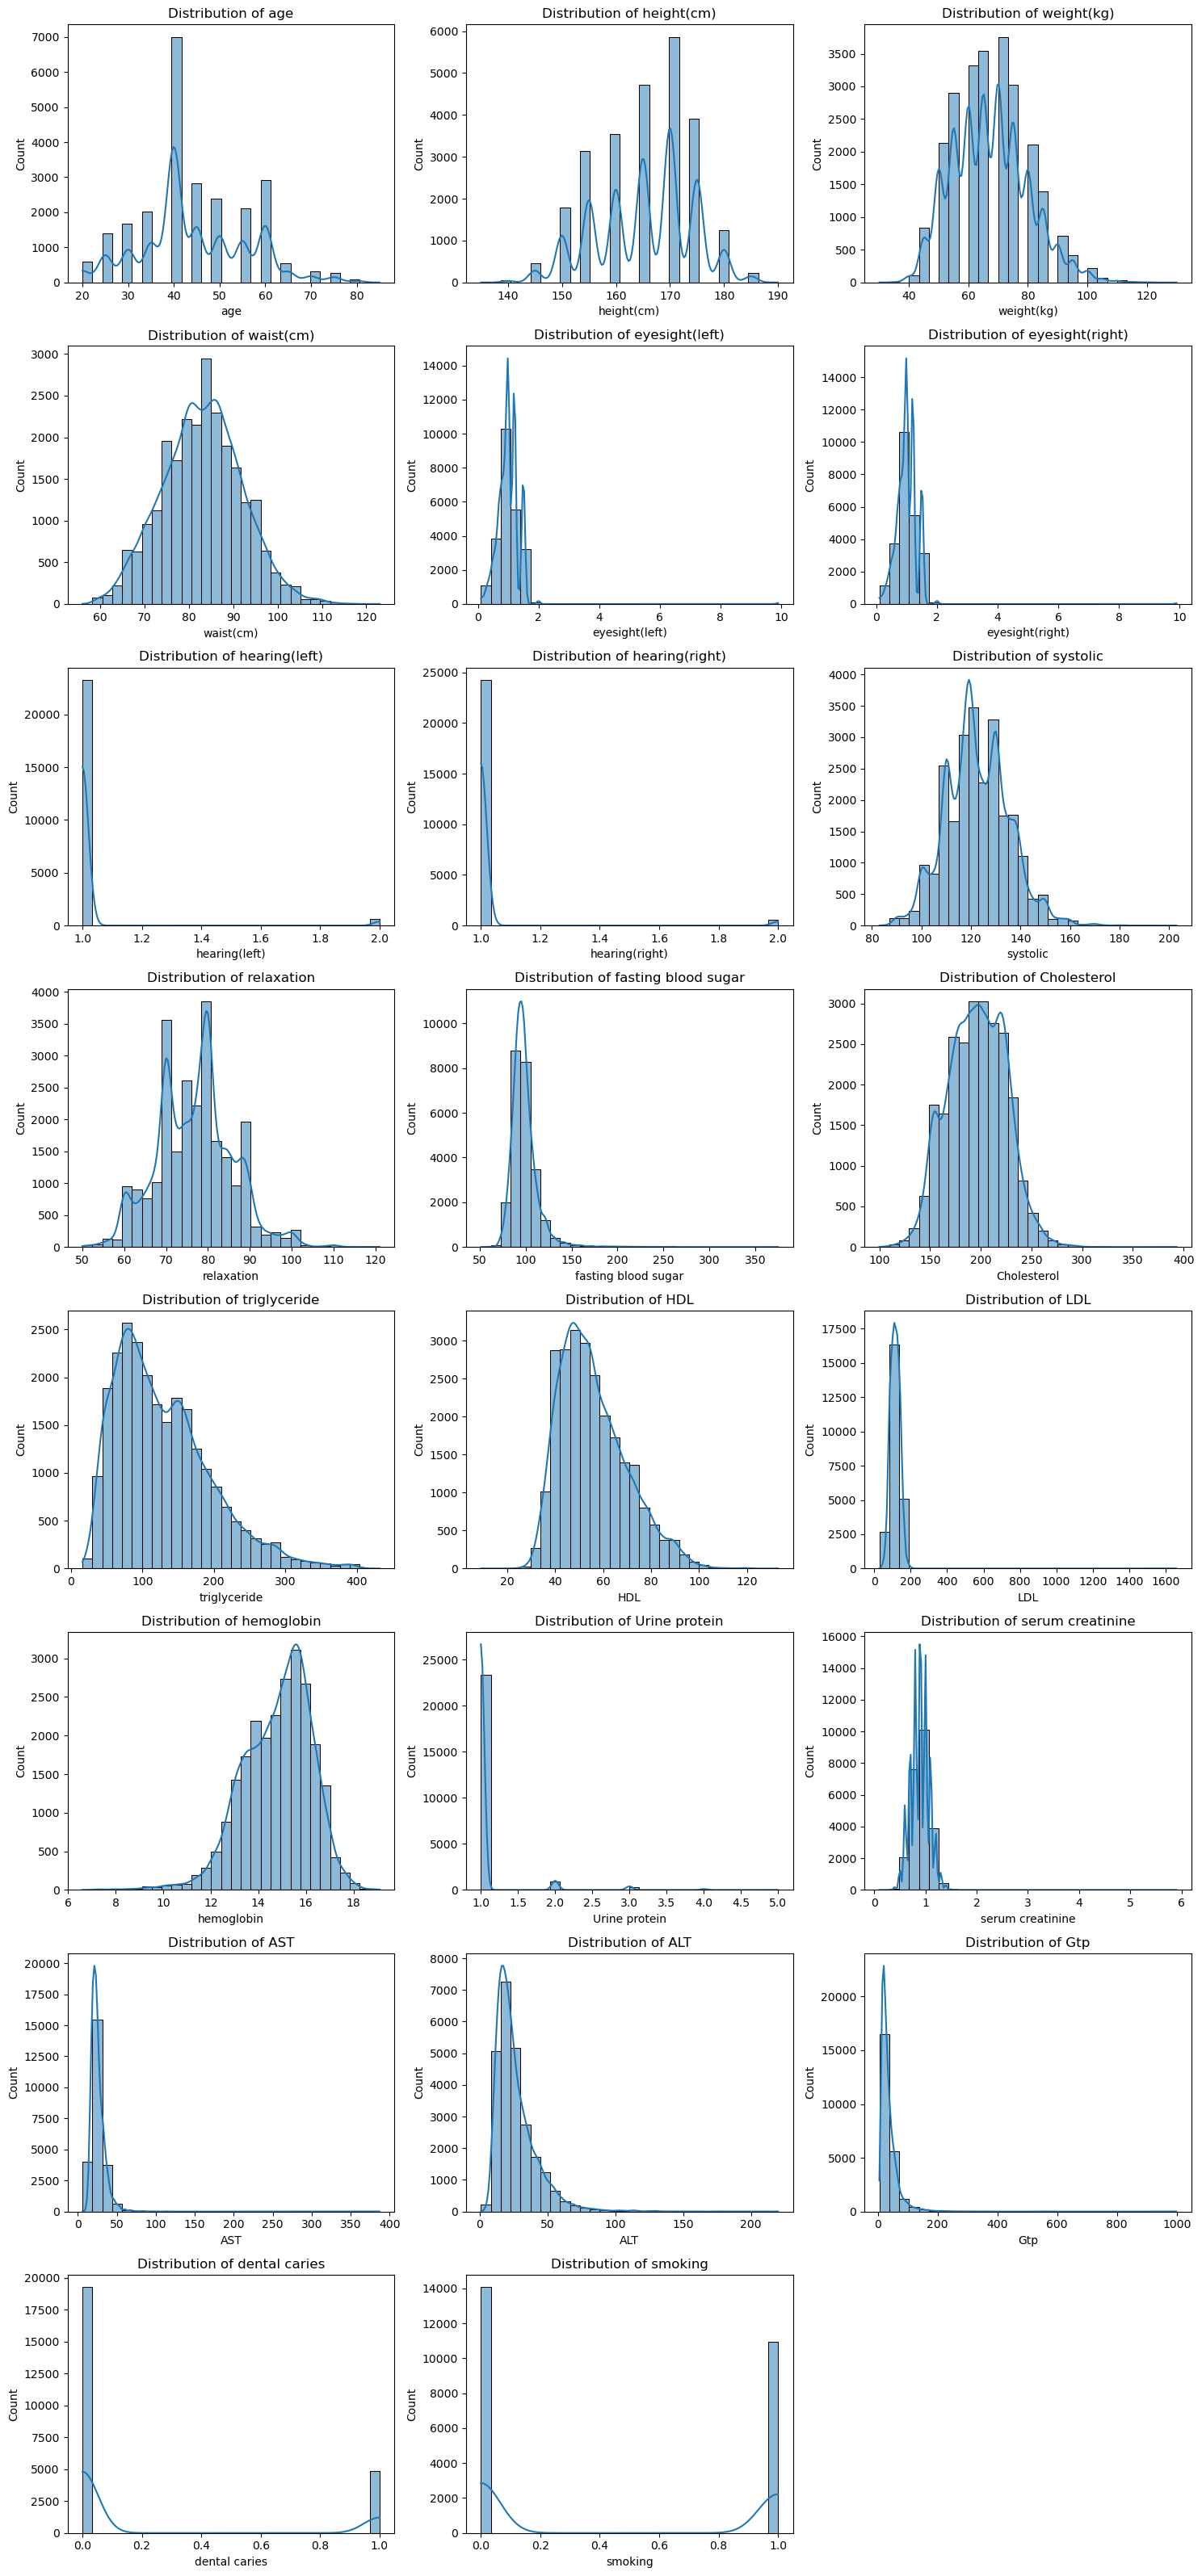

In [10]:
# Plotting distributions of numerical columns in the dataset
numerical_columns = train_set.select_dtypes(include=['float64', 'int64']).columns
n_cols = 3
n_rows = len(numerical_columns) // n_cols + (len(numerical_columns) % n_cols > 0)

plt.figure(figsize=(15, n_rows * 4))
for i, col in enumerate(numerical_columns):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(dataset[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

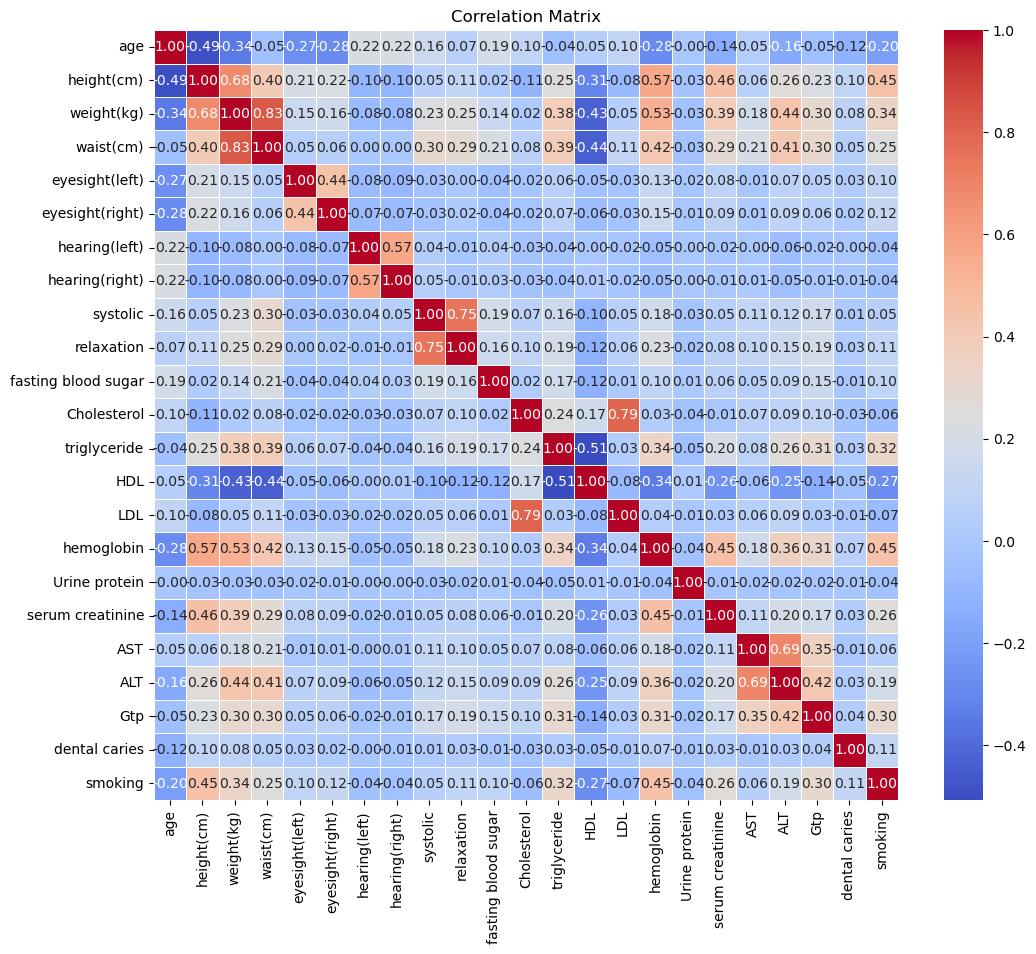

In [11]:
# Creating a correlation matrix
correlation_matrix = train_set.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

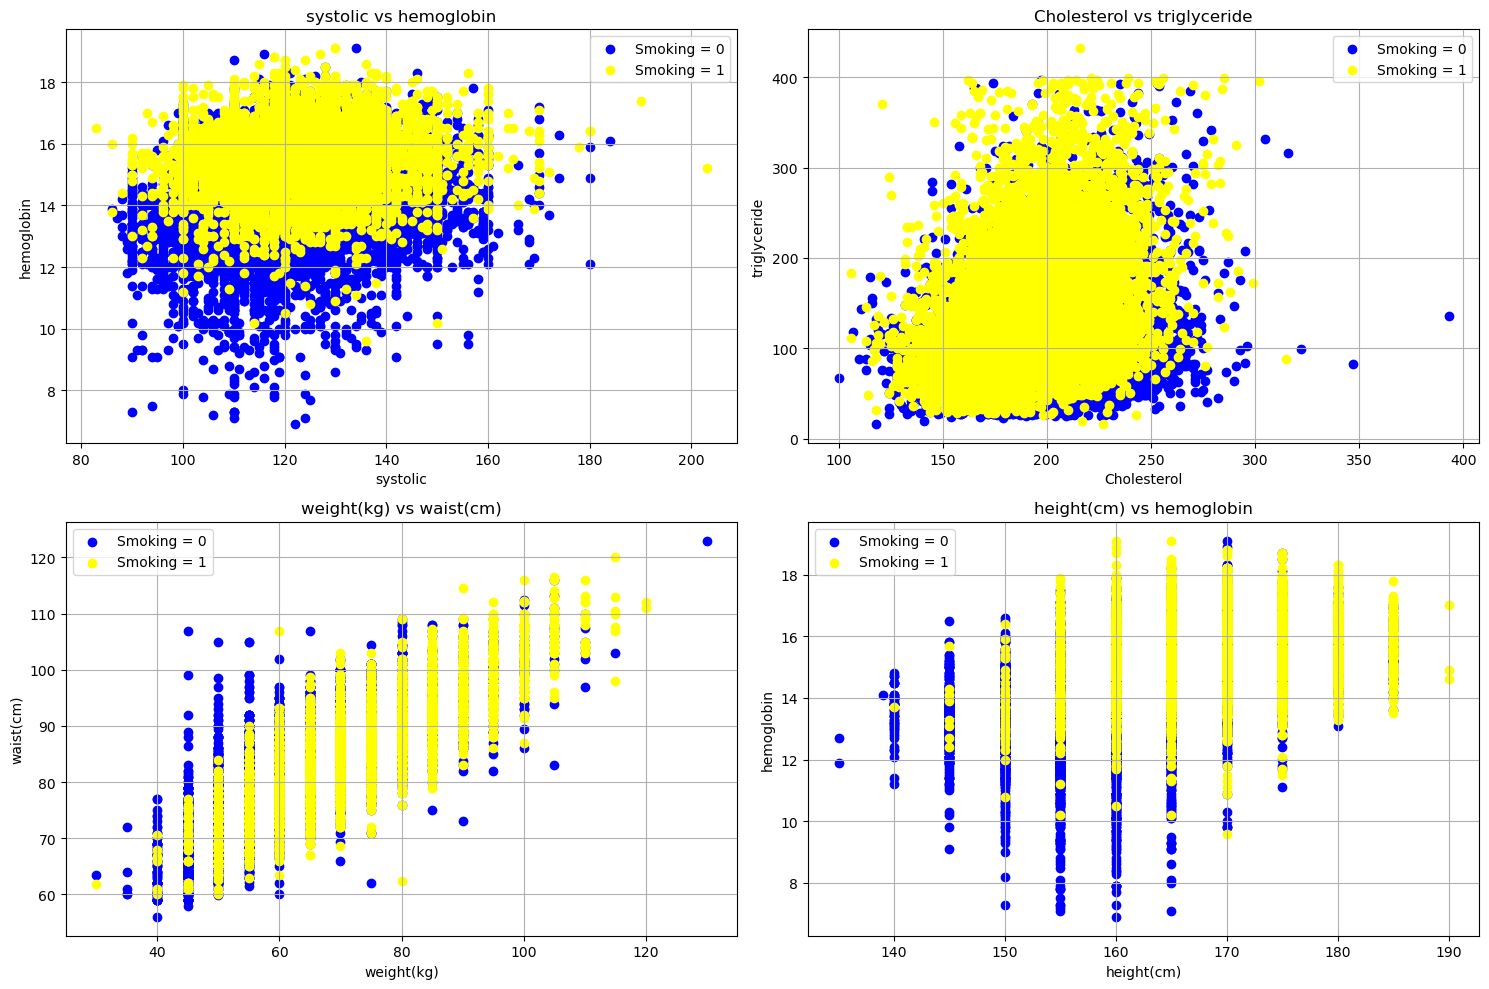

In [12]:
# Coppie di features da plottare
feature_pairs = [
    ('systolic', 'hemoglobin'),
    ('Cholesterol', 'triglyceride'),
    ('weight(kg)', 'waist(cm)'),
    ('height(cm)', 'hemoglobin')
]

# Creazione della griglia di scatter plots
plt.figure(figsize=(15, 10))
for i, (feature_x, feature_y) in enumerate(feature_pairs, 1):
    plt.subplot(2, 2, i)
    for smoking_status, color in zip([0, 1], ['blue', 'yellow']):
        subset = train_set[train_set['smoking'] == smoking_status]
        plt.scatter(subset[feature_x], subset[feature_y], c=color, label=f'Smoking = {smoking_status}')
    plt.title(f'{feature_x} vs {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Implementing Custom Transformers for Feature Engineering

Developed custom transformers to generate new features, enhancing the data engineering stage of our analysis pipeline.

# BMI
Computed and evaluated Body Mass Index (BMI) to assess obesity and its potential health implications in the dataset.

In [13]:
class BMITransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for BMI calculation
        return self
    
    def transform(self, X, y=None):
        weight = X['weight(kg)']
        height = X['height(cm)']

        # Calculate BMI
        bmi = weight / (height / 100) ** 2  # height is converted from cm to m
        
        
        # Return BMI in the expected shape
        return bmi.values.reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return ['bmi']

# Feature Creation: Eyesight Indicator

Introduced a new feature 'eyesight' set to 1 for individuals with less than 9/10 vision in at least one eye, based on the correlation between eyesight impairment and smoking.

In [14]:
class EyesightTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary
        return self
    
    def transform(self, X, y=None):

        # 1 if at least one of the two columns has value > 1, otherwise 0
        eyesight_condition = (X['eyesight(left)'] > 1) | (X['eyesight(right)'] > 1)
        result = eyesight_condition.astype(int)

        # If both columns have Nan assign 0
        both_nan = X['eyesight(left)'].isna() & X['eyesight(right)'].isna()
        result[both_nan] = 0

        return result.values.reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return ['eyesight_condition']

# Pulse Pressure Evaluation

Analyzed pulse pressure, the difference between systolic and diastolic blood pressure, as an indicator of cardiovascular health and arterial stiffness.

In [15]:
class PulsePressureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for pulse pressure calculation
        return self

    def transform(self, X, y=None):
        # Ensure the required columns are in the DataFrame
        if 'systolic' not in X or 'relaxation' not in X:
            raise ValueError("DataFrame must contain 'systolic' and 'relaxation' columns")

        # Calculate pulse pressure
        pulse_pressure = X['systolic'] - X['relaxation']

        # Return pulse pressure in the expected shape
        return pulse_pressure.values.reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return ['pulse_pressure']

# Blood Pressure and Hypertension

Explored blood pressure metrics in the dataset to understand hypertension, a key health condition often associated with various risk factors including lifestyle choices.

In [16]:
class BloodPressureCategoryTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for blood pressure categorization
        return self

    def transform(self, X, y=None):
        # Ensure the required columns are in the DataFrame
        if 'systolic' not in X or 'relaxation' not in X:
            raise ValueError("DataFrame must contain 'systolic' and 'relaxation' columns")

        # Define the blood pressure ranges
        normal_range = (X['systolic'] < 120) & (X['relaxation'] < 80)
        prehypertension_range = ((X['systolic'] >= 120) & (X['systolic'] < 130)) | ((X['relaxation'] >= 80) & (X['relaxation'] < 85))
        hypertension_stage_1_range = ((X['systolic'] >= 130) & (X['systolic'] < 140)) | ((X['relaxation'] >= 85) & (X['relaxation'] < 90))
        hypertension_stage_2_range = (X['systolic'] >= 140) | (X['relaxation'] >= 90)

        # Categorize blood pressure
        blood_pressure_category = pd.Series('Normal', index=X.index)
        blood_pressure_category[prehypertension_range] = 'Prehypertension'
        blood_pressure_category[hypertension_stage_1_range] = 'Hypertension Stage 1'
        blood_pressure_category[hypertension_stage_2_range] = 'Hypertension Stage 2'

        # Return the category in the expected shape
        return blood_pressure_category.values.reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return ['blood_pressure_category']


# AST to ALT Ratio Analysis

Investigated the ratio of AST (Aspartate Aminotransferase) to ALT (Alanine Aminotransferase) levels, a crucial metric in assessing liver health and function.

In [17]:
class ASTALTRatioTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for AST/ALT ratio calculation
        return self

    def transform(self, X, y=None):
        # Ensure the required columns are in the DataFrame
        if 'AST' not in X or 'ALT' not in X:
            raise ValueError("DataFrame must contain 'AST' and 'ALT' columns")

        # Calculate AST/ALT ratio
        ast_alt_ratio = X['AST'] / X['ALT']

        # Replace potential infinite values due to division by zero
        ast_alt_ratio = ast_alt_ratio.replace([np.inf, -np.inf], np.nan)

        # Return AST/ALT ratio in the expected shape
        return ast_alt_ratio.values.reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return ['ast_alt_ratio']


# Comprehensive Data Preprocessing: Tailored Pipelines

Constructed a data preprocessor with specialized pipelines: 
- **Standard scaling** for bell-shaped distributions with outliers
- **Min-max scaling** for uniform distributions
- **KNN imputation** for features highly correlated with smoking
- **Median imputation** for low-correlation features
- **Custom transformers** to create new features ('bmi', 'eyesight_condition', 'pulse_pressure', 'blood_pressure_category', 'ast_alt_ratio')
- **One-hot encoding** for hypertension categories.

In [18]:
# Columns for different imputation strategies
high_corr_cols = ['weight(kg)', 'height(cm)', 'triglyceride', 'hemoglobin', 'waist(cm)', 
                  'Gtp', 'serum creatinine', 'ALT', 'HDL']
low_corr_cols = train_set.columns.drop(high_corr_cols + ['smoking'])

# Columns for different scalers
standard_scaler_cols = ['weight(kg)', 'height(cm)', 'hemoglobin', 'HDL']
minmax_scaler_cols = train_set.columns.drop(standard_scaler_cols + ['smoking'])

high_corr_cols_std = ['weight(kg)', 'height(cm)', 'hemoglobin', 'HDL']
low_corr_cols_std = ['Gtp', 'ALT', 'AST', 'serum creatinine', 'Urine protein', 'LDL', 'triglyceride', 'fasting blood sugar', 'eyesight(left)', 'eyesight(right)']
high_corr_cols_minmax = ['waist(cm)']
low_corr_cols_minmax = train_set.columns.drop(high_corr_cols_std + low_corr_cols_std + high_corr_cols_minmax +['smoking'])

# Define the pipelines
pipeline_std_scaler_high_corr = Pipeline([
    ('imputer', KNNImputer(n_neighbors=8)),
    ('scaler', StandardScaler())
])

pipeline_std_scaler_low_corr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

pipeline_minmax_scaler_high_corr = Pipeline([
    ('imputer', KNNImputer(n_neighbors=8)),
    ('scaler', MinMaxScaler())
])

pipeline_minmax_scaler_low_corr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Define the pipelines
pipeline_bmi = Pipeline([
    ('bmi', BMITransformer()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
    
])

# Define the pipelines
pipeline_pulse_pressure = Pipeline([
    ('bmi', PulsePressureTransformer()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Define the pipeline for blood pressure category
pipeline_blood_pressure_category = Pipeline([
    ('blood_pressure_category', BloodPressureCategoryTransformer()),
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Assuming categorical data
    ('encoder', OneHotEncoder())  # If you need to encode the categories
])
# Define the pipeline for AST/ALT ratio
pipeline_ast_alt_ratio = Pipeline([
    ('ast_alt_ratio', ASTALTRatioTransformer()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('bmi', pipeline_bmi, ['weight(kg)', 'height(cm)']),
        ('eyesight_condition', EyesightTransformer(), ['eyesight(left)', 'eyesight(right)']),
        ('pulse_pressure', pipeline_pulse_pressure, ['systolic', 'relaxation']),
        ('blood_pressure_category', pipeline_blood_pressure_category, ['systolic', 'relaxation']),
        ('ast_alt_ratio', pipeline_ast_alt_ratio, ['AST', 'ALT']),
        ('high_corr_std', pipeline_std_scaler_high_corr, high_corr_cols_std),
        ('low_corr_std', pipeline_std_scaler_low_corr, low_corr_cols_std),
        ('high_corr_minmax', pipeline_minmax_scaler_high_corr, high_corr_cols_minmax),
        ('low_corr_minmax', pipeline_minmax_scaler_low_corr, low_corr_cols_minmax)
    ],
    remainder='passthrough'  # To keep columns not specified in the transformer
)


In [19]:
y_train = train_set['smoking'] 
X_train = train_set.drop('smoking', axis=1)
y_test = test_set['smoking'] 
X_test = test_set.drop('smoking', axis=1)  

In [20]:
# Applying the transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Displaying the shape of the transformed datasets
X_train_transformed.shape, X_test_transformed.shape

((20000, 30), (5000, 30))

# Post-Transformation Dataset Insights

In [21]:
X_train_transformed_columns=['bmi', 'eyesight_condition', 'pulse_pressure',  'blood_pressure_category_1', 'blood_pressure_category_2', 'blood_pressure_category_3', 'blood_pressure_category_4', 'ast_alt_ratio'] +  high_corr_cols_std + low_corr_cols_std + high_corr_cols_minmax + low_corr_cols_minmax.tolist() 
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=X_train_transformed_columns)
X_train_transformed_df

,bmi,eyesight_condition,pulse_pressure,blood_pressure_category_1,blood_pressure_category_2,blood_pressure_category_3,blood_pressure_category_4,ast_alt_ratio,weight(kg),height(cm),...,eyesight(left),eyesight(right),waist(cm),age,hearing(left),hearing(right),systolic,relaxation,Cholesterol,dental caries
0,0.342000,0.0,0.409449,0.0,1.0,0.0,0.0,0.016350,-0.180372,-0.026831,...,-0.013710,0.001212,0.443284,0.461538,0.0,0.0,0.475000,0.563380,0.337884,0.0
1,0.311429,1.0,0.338583,0.0,0.0,1.0,0.0,0.026886,0.219350,1.111204,...,0.480336,0.528083,0.388060,0.307692,0.0,0.0,0.275000,0.352113,0.474403,0.0
2,0.300443,1.0,0.338583,0.0,0.0,1.0,0.0,0.018256,-0.180372,0.542187,...,0.480336,-0.525659,0.328358,0.307692,0.0,0.0,0.275000,0.352113,0.273038,0.0
3,0.312500,0.0,0.370079,0.0,0.0,0.0,1.0,0.035506,-0.979817,-1.164865,...,-0.260732,-0.789095,0.388060,0.307692,0.0,0.0,0.325000,0.380282,0.293515,0.0
4,0.262398,0.0,0.393701,0.0,0.0,1.0,0.0,0.010850,-0.180372,1.111204,...,-0.013710,-0.789095,0.358209,0.000000,0.0,0.0,0.291667,0.281690,0.269625,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.231692,0.0,0.330709,0.0,0.0,0.0,1.0,0.034270,-0.979817,-0.026831,...,-0.013710,0.001212,0.223881,0.307692,0.0,0.0,0.308333,0.422535,0.331058,1.0
19996,0.458520,1.0,0.330709,1.0,0.0,0.0,0.0,0.010431,1.418517,1.111204,...,0.480336,0.001212,0.555224,0.153846,0.0,0.0,0.350000,0.492958,0.426621,1.0
19997,0.387512,0.0,0.440945,1.0,0.0,0.0,0.0,0.014495,-0.180372,-0.595848,...,-0.260732,-0.789095,0.485075,0.384615,0.0,0.0,0.391667,0.366197,0.225256,0.0
19998,0.360459,1.0,0.393701,0.0,0.0,0.0,1.0,0.015810,0.619072,1.111204,...,0.480336,-1.579401,0.492537,0.153846,0.0,0.0,0.333333,0.352113,0.470990,0.0


# Cross-Validation for Classifier Selection

In this analysis, we aim to identify the top three classifiers among a set of nine classifiers. We will use cross-validation to evaluate their performance and select the best-performing ones for a more detailed hyperparameter search.

The classifiers under consideration are as follows:

- **Dummy**: A baseline classifier using the most frequent strategy.
- **Logistic Regression**: Logistic regression classifier with a maximum iteration limit.
- **KNN (K-Nearest Neighbors)**: K-Nearest Neighbors classifier.
- **SVM (Support Vector Machine)**: Support Vector Machine classifier.
- **Decision Tree**: Decision Tree classifier.
- **Random Forest**: Random Forest classifier.
- **GBM (Gradient Boosting Machine)**: Gradient Boosting Machine classifier.
- **AdaBoost**: AdaBoost classifier.
- **XGBoost**: XGBoost classifier with specific settings.

We will perform cross-validation to assess their performance, and based on the results, we will select the top three classifiers for a more extensive hyperparameter search.

The goal is to choose the most suitable classifiers for further tuning and optimization.

In [22]:
# Create a list of classifiers
classifiers = {
    "Dummy": DummyClassifier(strategy="most_frequent"),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "GBM": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


# Iterate over classifiers
for name, clf in classifiers.items():
    # Create a new instance of the model pipeline for each classifier
    model_pipeline = IMBPipeline([
        ('trans', preprocessor),
        ('dim_reduction', 'passthrough'),  # Use "passthrough" for dimensionality reduction
        ('classifier', clf)
    ])
    
    # Perform cross-validation and store results
    scores = cross_val_score(model_pipeline, X_train, y_train, cv=4, n_jobs = -1, scoring='accuracy')
    print(name + ':'+ str(scores.mean()))

Dummy:0.5616
Logistic Regression:0.74835
KNN:0.7164
SVM:0.76295
Decision Tree:0.6802999999999999
Random Forest:0.7627
GBM:0.7708
AdaBoost:0.76155
XGBoost:0.7563


## Dimensionality Reduction Configurations

1. **No Dimensionality Reduction**: 
     - Applies no dimensionality reduction.

2. **PCA (Principal Component Analysis)**:
     - Reduces dataset dimensionality, keeping components with specified variance.

3. **LDA (Linear Discriminant Analysis)**:
     - Focuses on maximizing class separability.

## Classifier Configurations

1. **SVM (Support Vector Machine)**:
   - Key Hyperparameters:
     - `C`: Regularization intensity.
     - `kernel`: Type of kernel used.
     - `gamma`: Kernel coefficient.
     - `class_weight`: Balancing class weights.
     - `degree`, `coef0`: Specific to 'poly' kernel.
     - `shrinking`, `tol`, `max_iter`: Optimization and termination controls.

2. **Random Forest**:
   - Key Hyperparameters:
     - `n_estimators`: Number of trees.
     - `max_depth`: Depth of trees.
     - `min_samples_split`, `min_samples_leaf`: Node splitting criteria.
     - `class_weight`: Class weighting method.
     - `max_features`: Features for best split.
     - `bootstrap`: Bootstrapping method.
     - `criterion`: Split quality measure.

3. **GBM (Gradient Boosting Machine)**:
   - Key Hyperparameters:
     - `n_estimators`: Number of boosting stages.
     - `learning_rate`: Impact of each tree.
     - `subsample`: Fraction of samples for base learners.
     - `min_samples_split`, `min_samples_leaf`: Node splitting criteria.
     - `max_depth`, `max_features`: Tree structure and feature considerations.
     - `tol`: Optimization termination control.


In [23]:
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    }
]


classifier_configs = [
    {
        'classifier': [SVC()],
        'classifier__C': loguniform(0.001, 100),
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__gamma': ['scale', 'auto'] + list(loguniform(0.001, 1).rvs(size=3)),
        'classifier__class_weight': [None, 'balanced'],
        'classifier__degree': [2, 3, 4, 5],
        'classifier__coef0': [-1.0, 0.0, 1.0],
        'classifier__shrinking': [True, False],
        'classifier__tol': loguniform(1e-6, 1e-3),
        'classifier__max_iter': [500, 1000, -1]
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 50, 100, 200, 500],
        'classifier__max_depth': [None, 10, 20, 30, 40, 50],
        'classifier__min_samples_split': [2, 5, 10, 15],
        'classifier__min_samples_leaf': [1, 2, 4, 6],
        'classifier__class_weight': [None, 'balanced', 'balanced_subsample'],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
        'classifier__bootstrap': [True, False],
        'classifier__criterion': ['gini', 'entropy']
    },
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [10, 50, 100, 200, 500],
        'classifier__learning_rate': loguniform(0.01, 1),
        'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_depth': [3, 5, 7, 9],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
        'classifier__tol': loguniform(1e-4, 1e-1)
    }
]


In [24]:
all_configs = []
for configuration in itertools.product(dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters)) # by dict(all_parameters) we create a dict from a list of pairs (key:value)

In [28]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 3,
    scoring='f1'
)

In [29]:
scores = cross_validate(rs, X_train, y_train, scoring='f1', cv = 5,  n_jobs = -1, return_estimator=True, verbose=3) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 25.1min remaining: 37.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 62.2min finished


In [30]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_params_['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'], estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-' * 10)

None
GradientBoostingClassifier(learning_rate=0.013037627466550362, max_depth=5,
                           max_features='auto', min_samples_leaf=4,
                           n_estimators=500, subsample=0.9,
                           tol=0.005762230366904379) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.013037627466550362, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_iter_no_change': None, 'random_state': None, 'subsample': 0.9, 'tol': 0.005762230366904379, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.7563249001331557
----------
None
GradientBoostingClassifier(learning_rate=0.06421281029959106, max_depth=5,
                           max_features='auto', min_samples_leaf=2,
                           min_samples_split=10, n_estimators=50, subsample=0.6,
     

# HalvingSearch for Hyperparameter Tuning

In the upcoming steps, we'll employ the HalvingSearch strategy to optimize the hyperparameters of our Random Forest classifier. This approach allows us to efficiently search through a multi-dimensional hyperparameter space by iteratively selecting the best performing subsets and then halving the search space. It's a resource-friendly method that aims to identify the most promising hyperparameters to enhance the model's performance.


In [33]:
# Define your RandomForest classifier
clf = RandomForestClassifier()

# Define the pipeline
pipeline = Pipeline([
    ('trans', preprocessor), 
    ('dim_red', 'passthrough'),  # Dimensionality reduction
    ('classifier', clf)
])

# Define the parameter grid
param_grid = {
    'classifier__max_depth': [10, 30, 50, None],  # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at a leaf node
    'classifier__bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'classifier__class_weight': ['balanced', 'balanced_subsample', None]  # Weights associated with classes
}


# Create the HalvingRandomSearchCV object
search = HalvingRandomSearchCV(estimator=pipeline, param_distributions=param_grid,
                               resource='classifier__n_estimators', 
                               max_resources=500, n_jobs=-1,
                               random_state=42, aggressive_elimination=True)

# Fit to the data (assuming you have X_train and y_train)
search.fit(X_train, y_train)

# Print the best parameters
print(search.best_params_)

{'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10, 'classifier__class_weight': None, 'classifier__bootstrap': False, 'classifier__n_estimators': 243}


# Validation-Training Accuracy Graph

We've conducted the hyperparameter tuning and now it's time to visualize the model's performance. By plotting the validation-training accuracy graph, we can observe how the accuracy varies with increasing train set size.


In [36]:
# Best parameters from your HalvingRandomSearchCV
best_params = {
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_depth': 10,
    'class_weight': None,
    'bootstrap': False,
    'n_estimators': 243
}

# Create the RandomForestClassifier with the best parameters
rf_classifier = RandomForestClassifier(**best_params)

cls = IMBPipeline([
    ('trans', preprocessor),
    ('dim_red', 'passthrough'),
    ('classifier',rf_classifier)  
])

(0.6, 1.03)

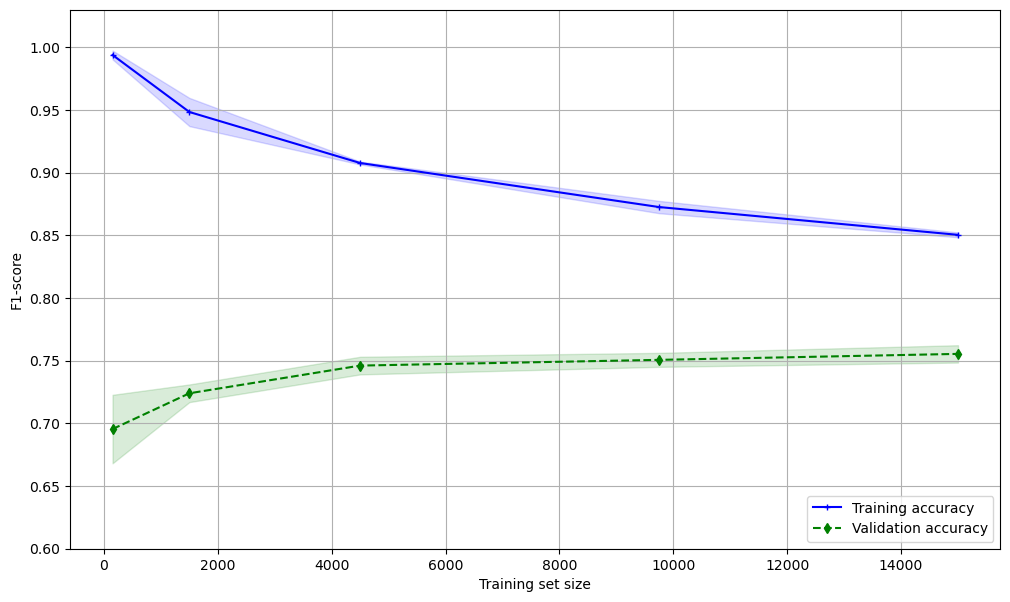

In [37]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.3, 0.65, 1.0],
                                                       cv = 4,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

# Manual Adjustment of Hyperparameters to Mitigate Overfitting
After analyzing the initial validation-training accuracy graph, we've identified signs of overfitting in our model. To address this, manual adjustments to the hyperparameters are necessary. By pruning the Random Forest and fine-tuning specific parameters, we aim to achieve a more balanced model that generalizes better to unseen data. 

(0.6, 1.03)

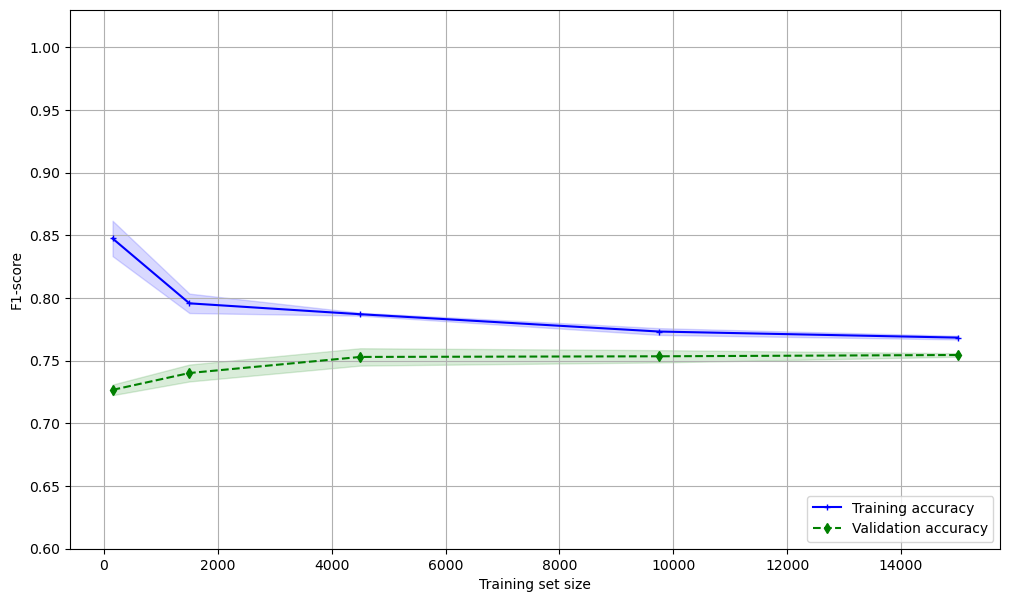

In [49]:
best_params = {
    'min_samples_split': 12,
    'min_samples_leaf': 8,
    'max_depth': 6,
    'class_weight': 'balanced',  
    'bootstrap': True,
    'n_estimators': 150
}

# Create the RandomForestClassifier with the best parameters
rf_classifier = RandomForestClassifier(**best_params)

cls = IMBPipeline([
    ('trans', preprocessor),
    ('dim_red', 'passthrough'),
    ('classifier',rf_classifier)  
])

train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.3, 0.65, 1.0],
                                                       cv = 4,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

# Creation of the Final Model Pipeline and Evaluation with Training Set

We've established the optimal hyperparameters and are now ready to construct the final model pipeline. This pipeline integrates preprocessing steps with our tuned Random Forest classifier. After training this robust model on our training set, we'll evaluate its performance by generating and analyzing the confusion matrix.

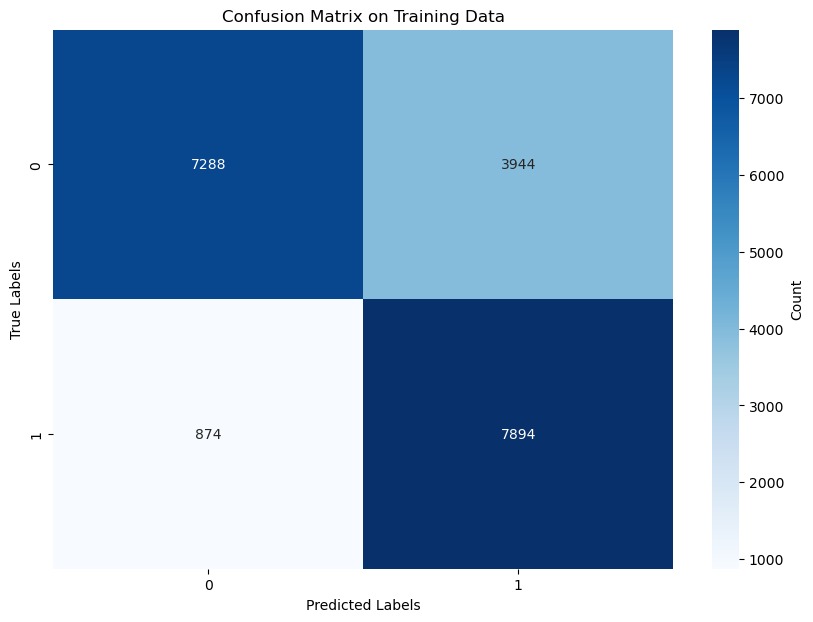

In [50]:
# Fit the classifier and make predictions
cls.fit(X_train, y_train)
train_predictions = cls.predict(X_train)

# Compute the confusion matrix
train_conf_matrix = confusion_matrix(y_train, train_predictions)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(train_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar_kws={'label': 'Count'})

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Training Data')

# Show the plot
plt.show()

# Visualization with ROC Curve

To further assess the predictive power of our model, we'll plot the ROC curve

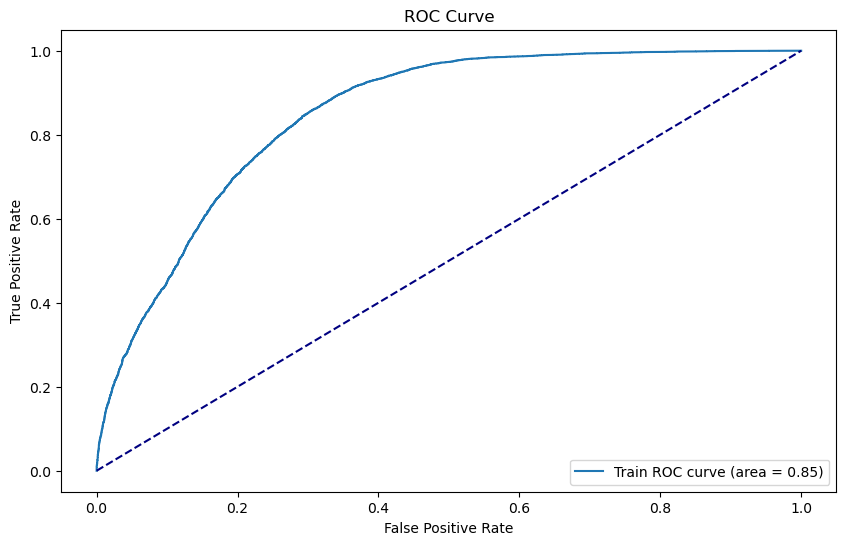

In [53]:
#Calculate Probability Scores
train_probs = cls.predict_proba(X_train)[:, 1]  # Probabilities for the positive class

#Plot ROC Curve and Calculate AUC for Training Set
train_fpr, train_tpr, _ = roc_curve(y_train, train_probs)
train_auc = auc(train_fpr, train_tpr)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, label=f'Train ROC curve (area = {train_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



# Analyzing Performance Across Different Thresholds

Different applications require different trade-offs between precision and recall. To explore these trade-offs, we'll create confusion matrices corresponding to a range of thresholds. This analysis will help us understand how varying the decision threshold affects the number of false positives and false negatives.

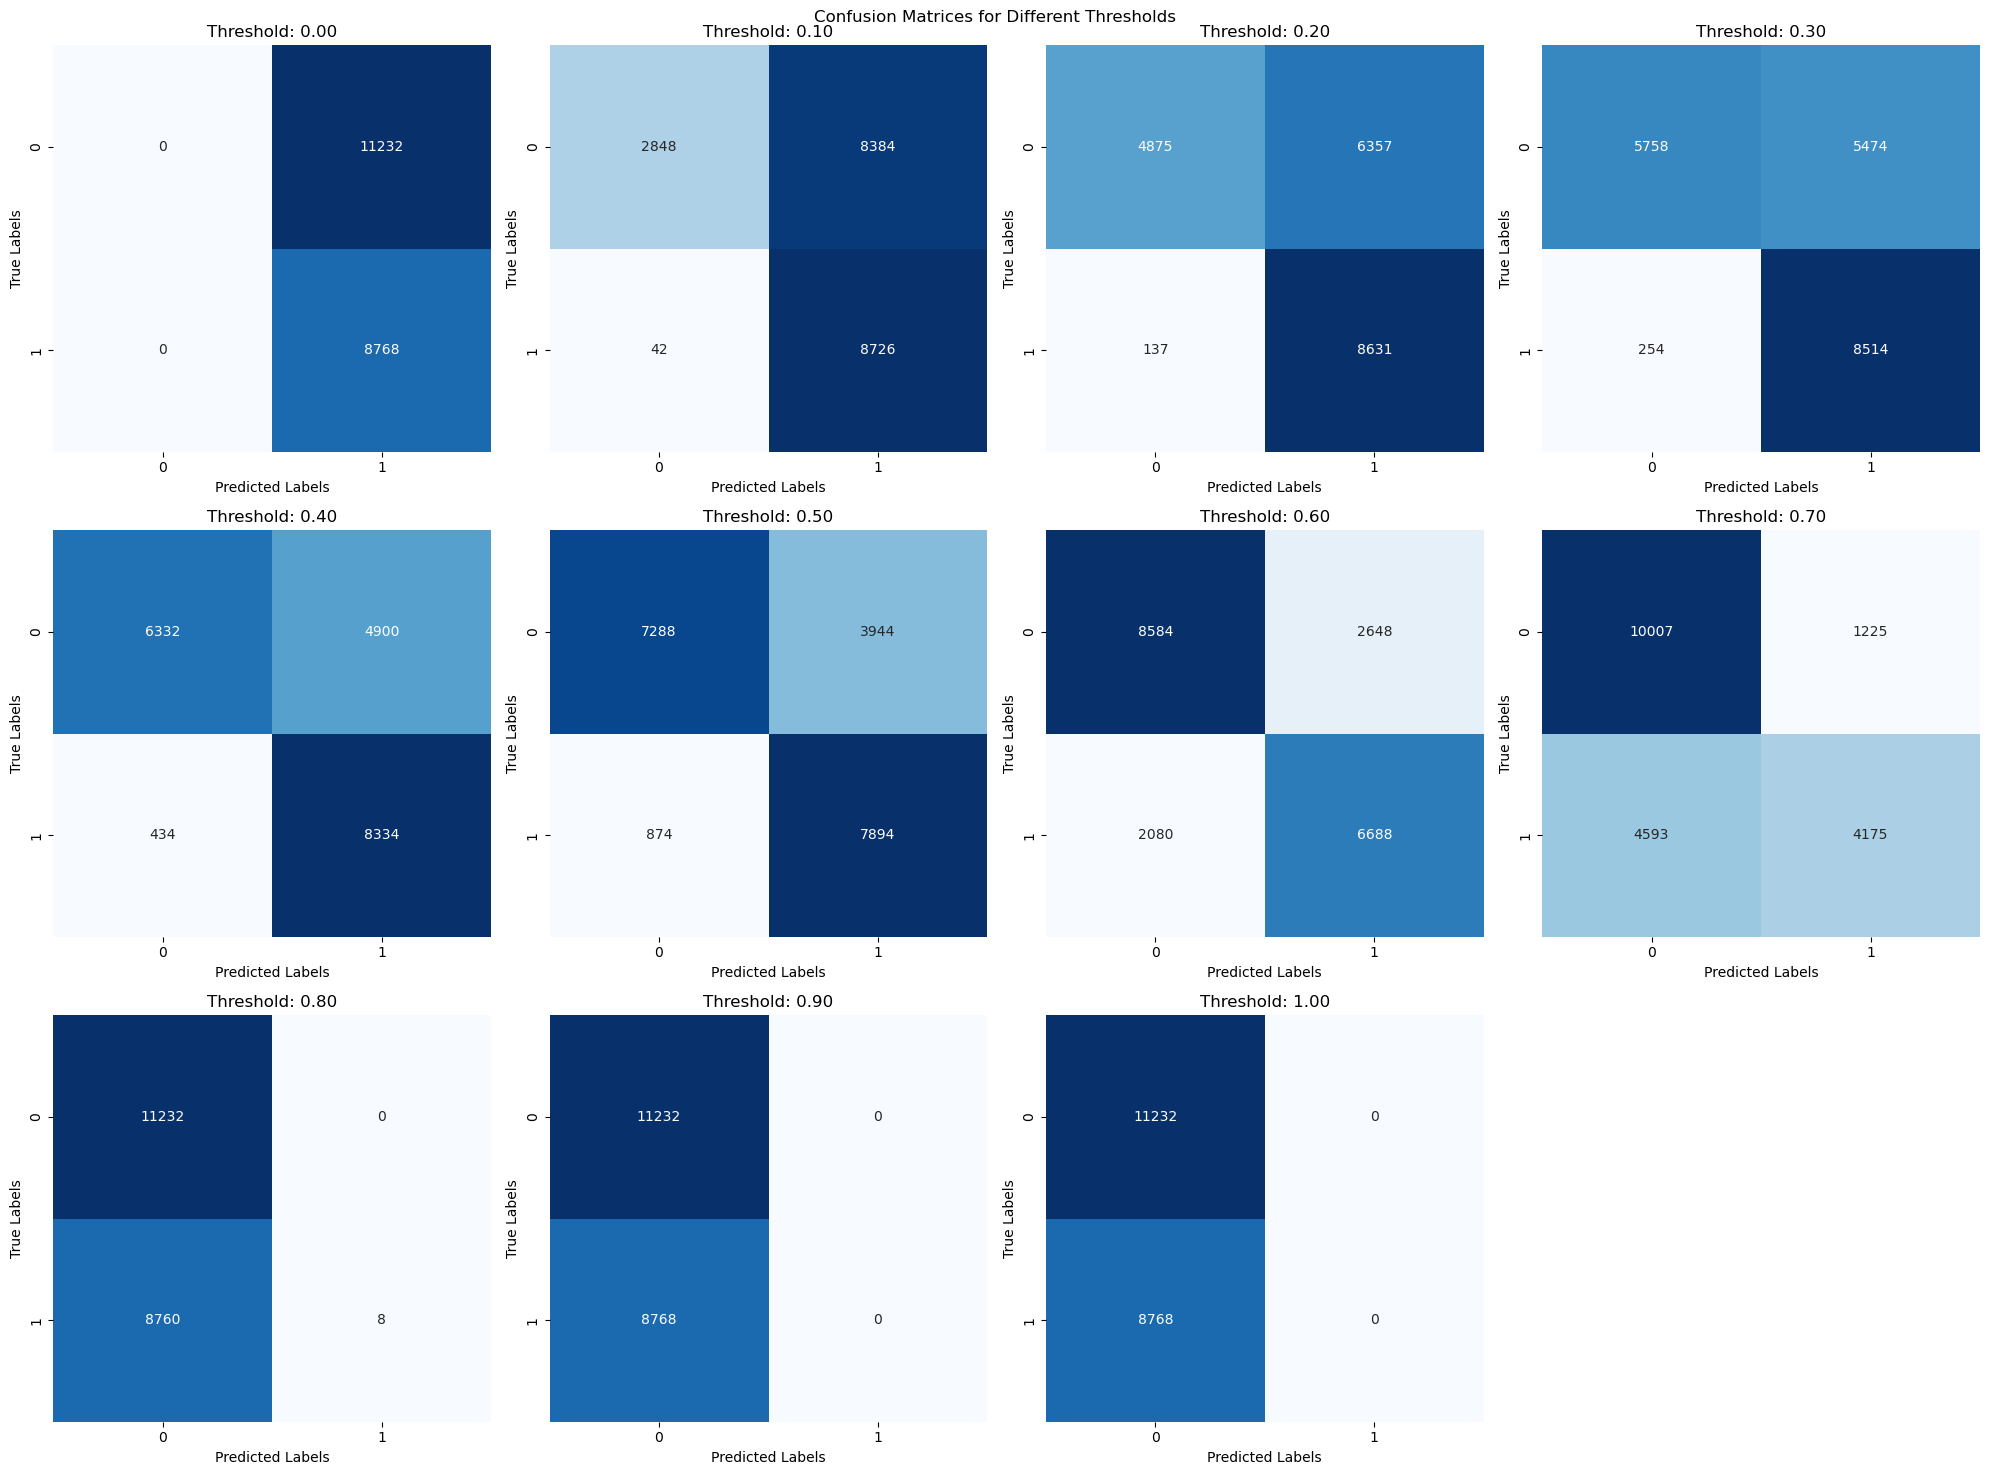

In [57]:
# Get the prediction probabilities for the positive class
probabilities = cls.predict_proba(X_train)[:, 1]

thresholds = [i/10 for i in range(11)]

# Define the grid size
n_rows = 3
n_cols = 4

# Set up the matplotlib figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
fig.suptitle('Confusion Matrices for Different Thresholds')

for i, threshold in enumerate(thresholds):
    # Compute the row and column index for the current subplot
    row_idx = i // n_cols
    col_idx = i % n_cols
    
    # Apply threshold
    predictions = (probabilities >= threshold).astype(int)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_train, predictions)
    
    # Plot the heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=axes[row_idx, col_idx], cbar=False)
    axes[row_idx, col_idx].set_title(f'Threshold: {threshold:.2f}')
    axes[row_idx, col_idx].set_xlabel('Predicted Labels')
    axes[row_idx, col_idx].set_ylabel('True Labels')

# If there are any remaining empty subplots, turn them off
total_plots = n_rows * n_cols
for i in range(len(thresholds), total_plots):
    row_idx = i // n_cols
    col_idx = i % n_cols
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

# Optimal Threshold Selection for Maximizing Accuracy

Through our analysis, we've identified that a threshold of 0.55 maximizes the accuracy of our model. 

In [62]:
# Generate probability scores for the test set
train_probs = cls.predict_proba(X_train)[:, 1]

# Initialize the best accuracy and corresponding threshold
best_accuracy = 0
best_threshold = 0.5

# Iterate over a range of thresholds to find the best one
for threshold in np.linspace(0, 1, 100):
    # Convert probabilities to binary predictions based on the threshold
    test_preds = (test_probs >= threshold).astype(int)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_train, test_preds)
    # Update the best accuracy and threshold if current accuracy is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f'Best Threshold: {best_threshold}')
print(f'Best Accuracy: {best_accuracy}')


Best Threshold: 0.5454545454545455
Best Accuracy: 0.76665


# Final Model Testing and Validation
With our model tuned and the optimal threshold applied, it's time to put our Random Forest classifier to the test. We'll deploy the model on our test set and calculate key metrics such as accuracy, F1 score, and analyzing the confusion matrix.


In [63]:
def predict_with_custom_threshold(cls, X, threshold=0.55):
    probabilities = cls.predict_proba(X)[:, 1]  # Get probabilities for the positive class
    return (probabilities >= threshold).astype(int)  # Apply the custom threshold

In [68]:
# Make predictions using the custom threshold
predictions = predict_with_custom_threshold(cls, X_test, threshold=0.55)

# Calculate F1 score
f1 = f1_score(y_test, predictions)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Print the results
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")


F1 Score: 0.7529
Accuracy: 0.7632
Confusion Matrix:
[[2012  822]
 [ 362 1804]]
